# Homework3 - Interactive Viz
#### Group member: Shengzhao LEI - Tao SUN - Xiangzhe MENG

Here is the link for the whole Notebook: [HW3 - Interactive Data Visualization](https://nbviewer.jupyter.org/gist/xiangzhemeng/11d8742b1ef28c2ebcd3a27df403a091)

You can see all the result and maps fom this link!

In [1]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import json
import folium
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Question 1: Unemployment rate in Europe at a country level

The data is collected from [eurostat](http://ec.europa.eu/eurostat/data/database). And in the dataset are the monthly data of unemployment rate of most European coutries in 2017.

### Collect data and draw Choropleth map

Load data.

In [2]:
euro_data_path = r'data/ei_lmhr_m_1_Data.csv'
euro_data_raw = pd.read_csv(euro_data_path)

Basic data cleaning work.

In [3]:
# Select useful attributes
euro_unem = euro_data_raw[(euro_data_raw.UNIT == 'Percentage of active population') & 
                          (euro_data_raw.INDIC  == 'Unemployment according to ILO definition - Total')]\
                        [['TIME','GEO','Value']]
# Drop NaN
euro_unem.drop(euro_unem[euro_unem['Value']==':'].index,inplace=True)
# Drop unnecessary data
euro_unem.drop(euro_unem[euro_unem['GEO']=='Japan'].index,inplace=True)
euro_unem.drop(euro_unem[euro_unem['GEO']=='United States'].index,inplace=True)
# Change the type of rate
euro_unem.Value = euro_unem.Value.astype(float)
# Rename columns and countries
euro_unem = euro_unem.rename(columns={'GEO':'Country','Value':'Rate'})
euro_unem = euro_unem.replace('Germany (until 1990 former territory of the FRG)','Germany')

In [4]:
euro_unem.head()

,TIME,Country,Rate
0,2017M01,Belgium,7.6
9,2017M01,Bulgaria,6.6
18,2017M01,Czech Republic,3.3
27,2017M01,Denmark,6.1
36,2017M01,Germany,3.9


Calculate the monthly average unemployment rate of this year so far.

In [5]:
euro_unem_rate = euro_unem.groupby('Country').mean()

In [6]:
euro_unem_rate.head()

,Rate
Country,
Austria,5.555556
Belgium,7.388889
Bulgaria,6.266667
Croatia,11.211111
Cyprus,11.411111


Load the geo data of European.

In [7]:
euro_geo_path = r'topojson/europe.topojson.json'
euro_geo_data = json.load(open(euro_geo_path))

Create a 'mapping' which maps name of country to its code. 

In [8]:
code_dict = {co['id'] : co['properties']['NAME'] for co in euro_geo_data['objects']['europe']['geometries']}
code = pd.DataFrame(pd.Series(code_dict)).reset_index()
code = code.rename(columns={'index':'Code',0:'Country'})
code = code.set_index('Country')

In [9]:
code.head()

,Code
Country,
Andorra,AD
Albania,AL
Armenia,AM
Austria,AT
Azerbaijan,AZ


Merge two together.

In [10]:
euro_unem_rate_code = pd.merge(euro_unem_rate, code, left_index=True, right_index=True, how='left')

Check if we match every country.

In [11]:
euro_unem_rate_code[euro_unem_rate_code.Code.isnull()]

,Rate,Code
Country,,


In [12]:
euro_unem_rate_code.head()

,Rate,Code
Country,,
Austria,5.555556,AT
Belgium,7.388889,BE
Bulgaria,6.266667,BG
Croatia,11.211111,HR
Cyprus,11.411111,CY


In order to get the central coordinates of each country, we use another dataset collected from the website of PSU, [Country Geography Data](https://www.pdx.edu/econ/country-geography-data).

In [13]:
country_geo_data_path = r'data/phys_geo.csv'
country_geo_raw = pd.read_csv(country_geo_data_path)

In [14]:
country_cen_geo = country_geo_raw[['country','cen_lat','cen_lon']]
country_cen_geo.columns = ['Country', 'lat', 'lon']
country_cen_geo = country_cen_geo.set_index('Country')

In [15]:
country_cen_geo.head()

,lat,lon
Country,,
Afghanistan,33.78231,66.16850
Angola,-12.35773,17.73944
Albania,41.14326,20.25988
United Arab Emirates,23.53906,54.30128
Argentina,-35.38706,-64.92097


In [16]:
euro_unem_rate_code_geo = pd.merge(euro_unem_rate_code, country_cen_geo,left_index=True,right_index=True,how='left')
# Modifiy a little bit
euro_unem_rate_code_geo.loc['Croatia','lat'] = 45.48
euro_unem_rate_code_geo.loc['Croatia','lon'] = 16.0
euro_unem_rate_code_geo.loc['Malta','lat'] = 35.54
euro_unem_rate_code_geo.loc['Malta','lon'] = 14.31
euro_unem_rate_code_geo.head()

,Rate,Code,lat,lon
Country,,,,
Austria,5.555556,AT,47.59834,14.315270
Belgium,7.388889,BE,50.66245,4.826458
Bulgaria,6.266667,BG,42.79115,25.349520
Croatia,11.211111,HR,45.48000,16.000000
Cyprus,11.411111,CY,35.03115,33.290250


Before drawing the choropleth, we notice that the dataset collected from the website mainly contains unemployment rates of EU countries not all European countries. So we need to modify the geo data a liitle bit.

Delete the countries in the geo_data of which we don't know unemployment rate.

In [17]:
import copy
euro_geo_used = copy.deepcopy(euro_geo_data)
for country_data in euro_geo_data['objects']['europe']['geometries']:
    if country_data['properties']['NAME'] not in euro_unem_rate_code.index:
        euro_geo_used['objects']['europe']['geometries'].remove(country_data)

Draw choropleth with geo data and unempolyment rate data presented above.

In [18]:
euro_unem_map = folium.Map([55,20], tiles='cartodbpositron', zoom_start=4)
euro_unem_map.choropleth(geo_data=euro_geo_used, data=euro_unem_rate_code,
             columns=['Code', 'Rate'],
             key_on='feature.id',topojson='objects.europe',
             fill_color='OrRd', fill_opacity=0.7, line_opacity=0.2,
             threshold_scale = [0,5,10,15,20,25],
             legend_name='Europen Unempolyment Rate (%)')

Add markers and popups to make the visualization interactive.

In [19]:
from folium import plugins

In [20]:
marker_cluster = plugins.MarkerCluster().add_to(euro_unem_map)

for country in euro_unem_rate_code_geo.index:
    lat = euro_unem_rate_code_geo.loc[country,'lat']
    lon = euro_unem_rate_code_geo.loc[country,'lon']
    rate = euro_unem_rate_code_geo.loc[country,'Rate']
    folium.Marker(
        location=[lat, lon],
        popup='{}:{:.2f}'.format(country,rate),
        icon=folium.Icon(color='red', icon='info-sign')
        ).add_to(marker_cluster)

In [21]:
euro_unem_map

In [22]:
euro_unem_map.save('euro_unem_map.html')

Now, you can see the map we draw with the link: [European Unempolyment Rate](euro_unem_map.html)

### Analysis

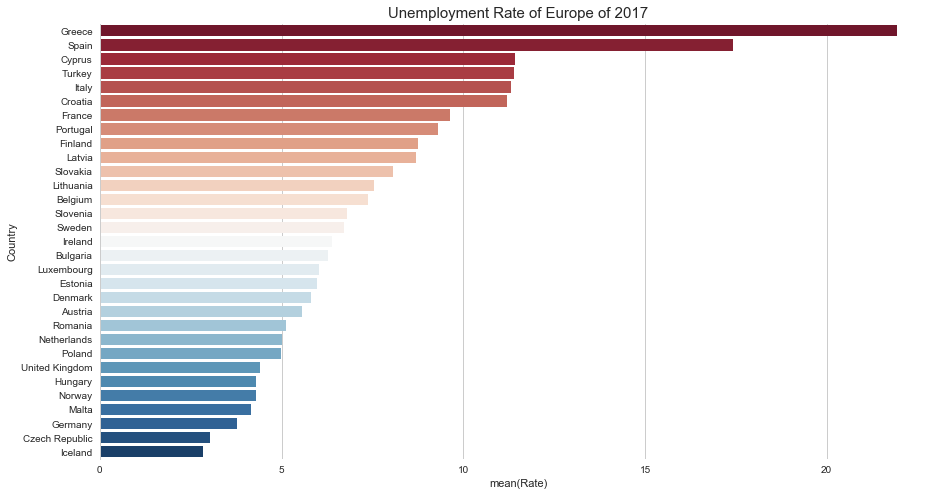

In [23]:
sns.set(style='whitegrid')
df_for_plot = euro_unem_rate.reset_index().sort_values('Rate',ascending = False)
plt.figure(figsize=(15,8))
ax = sns.barplot(y="Country", x="Rate", data=df_for_plot, palette="RdBu")
ax.set_title('Unemployment Rate of Europe of 2017',size=15)
sns.despine(bottom=True)

With the choropleth map and the bar plot above, we can see the big difference of unemployment rate across Europe. In Greece and Spain, the top 2 highest rate European countries, the unemployment rates are above 15% which partly reflects the economic situation of the two countries. Most of countries have a lower-than-10% unemployment rate. There are some countries with relatively low unemployment rate, below 5%, like Iceland, Germany, United Kingdom.

## Question 2: Unemployment rate at the level of Swiss cantons

**Overlay Switzerland canton boundaries on the map**

 First of all, we overlay the Switzerland canton boundaries onto the map.

In [24]:
switzerland_coord = [46.8,8.3]
m_switzerland = folium.Map(switzerland_coord, tiles='cartodbpositron', zoom_start=8)

In [25]:
state_geo_path = r'topojson/ch-cantons.topojson.json'
geo_json_data = json.load(open(state_geo_path))

**Import 2017 Switzerland unemployment rates data (From Jan. to Sept. + average)**

We choose a dataset which contains swiss unempolyment rate, the number of unemployer, the number of people looking for a job and the number of worker looking for a new job of the first 9 months 2017 and the average value of these attributes.

From the dataframe below, we can find that

$$unemployer  = people\_looking\_for\_a\_job - worker\_looking\_for\_a\_new\_job$$

In [26]:
df_switzerland_unemployment_rate = pd.read_excel("data/ch_unemployment_rate.xlsx")
df_switzerland_unemployment_rate = df_switzerland_unemployment_rate.drop('Unnamed: 1', axis = 1)
df_switzerland_unemployment_rate.columns = [['Canton','January','January','January','January','February','February','February','February','March','March','March','March','April','April','April','April','May','May','May','May','June','June','June','June','July','July','July','July','August','August','August','August','September','September','September','September','Total from Jan. to Sept. 2017','Total from Jan. to Sept. 2017','Total from Jan. to Sept. 2017','Total from Jan. to Sept. 2017'],
                                            ['','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job','unemployment rate','unemployer','people looking for a job','worker looking for a new job']]
df_switzerland_unemployment_rate = df_switzerland_unemployment_rate.drop([0,1,2,29],axis = 0)
df_switzerland_unemployment_rate = df_switzerland_unemployment_rate.set_index(['Canton'])
df_switzerland_unemployment_rate.head()

January                                      \
        unemployment rate unemployer people looking for a job   
Canton                                                          
Zurich                3.9      32387                    39340   
Berne                   3      16954                    21586   
Lucerne               2.2       4985                     7950   
Uri                   1.5        297                      464   
Schwyz                  2       1794                     2581   

                                              February             \
        worker looking for a new job unemployment rate unemployer   
Canton                                                              
Zurich                          6953               3.9      31619   
Berne                           4632                 3      16738   
Lucerne                         2965               2.2       4808   
Uri                              167               1.4        276   
Schwyz                           787                 2       1766   

                                                               \
        people looking for a job worker looking for a new job   
Canton                                                          
Zurich                     38748                         7129   
Berne                      21367                         4629   
Lucerne                     7857                         3049   
Uri                          457                          181   
Schwyz                      2568                          802   

                    March                        ...               \
        unemployment rate unemployer             ...                
Canton                                           ...                
Zurich                3.8      30841             ...                
Berne                 2.9      16035             ...                
Lucerne                 2       4493             ...                
Uri                   1.3        256             ...                
Schwyz                1.9       1670             ...                

                          August                               \
        people looking for a job worker looking for a new job   
Canton                                                          
Zurich                     34542                         7028   
Berne                      18393                         4564   
Lucerne                     6853                         2861   
Uri                          267                          144   
Schwyz                      2240                          774   

                September                                      \
        unemployment rate unemployer people looking for a job   
Canton                                                          
Zurich                3.3      27225                    34156   
Berne                 2.4      13658                    18385   
Lucerne               1.7       3885                     6756   
Uri                   0.6        112                      257   
Schwyz                1.7       1455                     2229   

                                     Total from Jan. to Sept. 2017             \
        worker looking for a new job             unemployment rate unemployer   
Canton                                                                          
Zurich                          6931                           3.6     263669   
Berne                           4727                           2.7     134156   
Lucerne                         2871                           1.9      38319   
Uri                              145                             1       1776   
Schwyz                           774                           1.8      14051   

                                                               
        people looking for a job worker looking for a new job  
Canton                                             

**Add canton code and canton coordinates to the dataframe**

In this part, we extract the columns **"canton" & "unemployment rate"** from the original dataframe and add two columns **"Code" & "Canton coordinates"** in order to construct a connection with the map.

In [27]:
df_ch_unemp_rate_v1 = df_switzerland_unemployment_rate.filter(items = [('Total from Jan. to Sept. 2017','unemployment rate')])
df_ch_unemp_rate_v1 = df_ch_unemp_rate_v1.reset_index()
df_ch_unemp_rate_v1['Total from Jan. to Sept. 2017','unemployment rate'] = df_ch_unemp_rate_v1['Total from Jan. to Sept. 2017','unemployment rate'].apply(pd.to_numeric)

In [28]:
code = ['ZH', 'BE', 'LU', 'UR', 'SZ', 'OW', 'NW', 'GL', 'ZG', 'FR', 'SO', 'BS', 'BL', 'SH', 'AR', 'AI', 
        'SG', 'GR', 'AG', 'TG', 'TI', 'VD', 'VS', 'NE', 'GE', 'JU']
canton_coord = [[47.4,8.6],[46.8,7.5],[47.08,8.17],[46.75,8.55],[47.0,8.7],[46.8,8.2],[46.9,8.4],[47.0,9.04],
                [47.15,8.55],[46.7,7.1],[47.31,7.65],[47.56,7.65],[47.43,7.85],[47.73,8.6],[47.30,9.25],[47.3,9.45],
                [47.18,9.24],[46.6,9.55],[47.4,8.17],[47.55,9.04],[46.25,8.8],[46.59,6.47],[46.1,7.45],[47.00,6.8],
                [46.2,6.05],[47.34,7.25]]
df_ch_unemp_rate_v1['Code'] = code
df_ch_unemp_rate_v1['Canton coordinates'] = canton_coord
df_ch_unemp_rate_v1.head()

,Canton,Total from Jan. to Sept. 2017,Code,Canton coordinates
,,unemployment rate,,
0,Zurich,3.6,ZH,"[47.4, 8.6]"
1,Berne,2.7,BE,"[46.8, 7.5]"
2,Lucerne,1.9,LU,"[47.08, 8.17]"
3,Uri,1.0,UR,"[46.75, 8.55]"
4,Schwyz,1.8,SZ,"[47.0, 8.7]"


**Generate the choropleth map**

In [29]:
m_switzerland_ue_rate = folium.Map(location = switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
m_switzerland_ue_rate.choropleth(geo_data=geo_json_data, data=df_ch_unemp_rate_v1,
             columns=[('Code',''), ('Total from Jan. to Sept. 2017','unemployment rate')],
             key_on='feature.id',topojson='objects.cantons',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='2017 Switzerland average unemployment rate (%)')

In this part, we add markers for each canton of Switzerland in order to show the unemployment rate in a more direct way. Users can click on the information icon to check the value. 

In [30]:
marker_cluster1 = plugins.MarkerCluster().add_to(m_switzerland_ue_rate)
for idx, coord in enumerate(df_ch_unemp_rate_v1['Canton coordinates']):
    folium.Marker(
        location=coord,
        popup=df_ch_unemp_rate_v1['Canton'][idx]+' unemployment rate: '+ str(df_ch_unemp_rate_v1[('Total from Jan. to Sept. 2017','unemployment rate')][idx]),
    ).add_to(marker_cluster1)

In [31]:
m_switzerland_ue_rate

In [32]:
m_switzerland_ue_rate.save('switzerland_ue_rate_map.html')

Now, you can see the map we draw with the link: [Switzerland Unempolyment Rate](switzerland_ue_rate_map.html)

**Define a new unemployment rate and show the new distribution in the map**

According to the README file, we know that the Swiss Confederation defines the rates as the number of people looking for a job divided by the size of the active population (scaled by 100). 

In this part, we decide to redefine the rate as:

$$ rate = \frac{unemployer}{active\_population}$$

We are supposed to calculate the active population with:

$$ active\_population = \frac{people\_looking\_for\_a\_job}{unemployment\_rate}$$

In [33]:
df_ch_unemp_rate_v2 = df_switzerland_unemployment_rate.filter(items = [('Total from Jan. to Sept. 2017','unemployment rate'),
                                                          ('Total from Jan. to Sept. 2017','unemployer'),
                                                          ('Total from Jan. to Sept. 2017','people looking for a job'),
                                                          ('Total from Jan. to Sept. 2017','worker looking for a new job')])
df_ch_unemp_rate_v2.head()

Total from Jan. to Sept. 2017                                      \
                    unemployment rate unemployer people looking for a job   
Canton                                                                      
Zurich                            3.6     263669                   327477   
Berne                             2.7     134156                   176193   
Lucerne                           1.9      38319                    65103   
Uri                                 1       1776                     3188   
Schwyz                            1.8      14051                    21229   

                                      
        worker looking for a new job  
Canton                                
Zurich                         63808  
Berne                          42037  
Lucerne                        26784  
Uri                             1412  
Schwyz                          7178

**Calculate the active population (the total population of one canton)**

In [34]:
df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','people looking for a job')] = df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','people looking for a job')].apply(pd.to_numeric)
df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','unemployment rate')] = df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','unemployment rate')].apply(pd.to_numeric)
df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','active population')] = df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','people looking for a job')] / (df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','unemployment rate')] / 100)
df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','active population')] = df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','active population')].astype(int)
df_ch_unemp_rate_v2 = df_ch_unemp_rate_v2.drop([('Total from Jan. to Sept. 2017','unemployment rate'),('Total from Jan. to Sept. 2017','people looking for a job'),('Total from Jan. to Sept. 2017','worker looking for a new job')],axis = 1)
df_ch_unemp_rate_v2.head()

Total from Jan. to Sept. 2017                  
                           unemployer active population
Canton                                                 
Zurich                         263669           9096583
Berne                          134156           6525666
Lucerne                         38319           3426473
Uri                              1776            318800
Schwyz                          14051           1179388

**Calculate the new unemployment rate**

In [35]:
df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','new unemployment rate')] = df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','unemployer')] / df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','active population')] * 100
df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','new unemployment rate')] = df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','new unemployment rate')].map('{:,.1f}'.format).apply(pd.to_numeric)
df_ch_unemp_rate_v2['Code'] = code
df_ch_unemp_rate_v2['Canton coordinates'] = canton_coord
df_ch_unemp_rate_v2 = df_ch_unemp_rate_v2.reset_index()
df_ch_unemp_rate_v2.head()

Canton Total from Jan. to Sept. 2017                    \
                              unemployer active population   
0   Zurich                        263669           9096583   
1    Berne                        134156           6525666   
2  Lucerne                         38319           3426473   
3      Uri                          1776            318800   
4   Schwyz                         14051           1179388   

                        Code Canton coordinates  
  new unemployment rate                          
0                   2.9   ZH        [47.4, 8.6]  
1                   2.1   BE        [46.8, 7.5]  
2                   1.1   LU      [47.08, 8.17]  
3                   0.6   UR      [46.75, 8.55]  
4                   1.2   SZ        [47.0, 8.7]

**Generate the new choropleth map**

In [36]:
m_switzerland_ue_rate_v2 = folium.Map(location = switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
m_switzerland_ue_rate_v2.choropleth(geo_data=geo_json_data, data=df_ch_unemp_rate_v2,
             columns=[('Code',''), ('Total from Jan. to Sept. 2017','new unemployment rate')],
             key_on='feature.id',topojson='objects.cantons',
             fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
             legend_name='2017 Switzerland average unemployment rate (%)')

In [37]:
marker_cluster2 = plugins.MarkerCluster().add_to(m_switzerland_ue_rate_v2)
for idx, coord in enumerate(df_ch_unemp_rate_v2['Canton coordinates']):
    folium.Marker(
        location=coord,
        popup=df_ch_unemp_rate_v2['Canton'][idx]+' unemployment rate: '+str(df_ch_unemp_rate_v2[('Total from Jan. to Sept. 2017','new unemployment rate')][idx]),
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(marker_cluster2)

In [38]:
m_switzerland_ue_rate_v2

In [39]:
m_switzerland_ue_rate_v2.save('switzerland_ue_new_rate_map.html')

Now, you can see the map we draw with the link: [Switzerland New Unempolyment Rate](switzerland_ue_new_rate_map.html)

**Observation & Analysis**

With the two maps above, we can observe that the unemployment rate in 5 French-speaking cantons (Vaud, Valais, Neuchâtel, Genève and Jura) is much higher than that in German-speaking cantons. The **worst situation** is always in the canton **Neuchâtel**. The unemployment rate distribution is very similar as well. Morever, we find that the rate for almost every cantons decreases more or less when we use unemployer (people who don't have a job looking for a job) to calculate it.

In order to prove our observation, we also plot a bar chart below. We find that, among the top 5 highest unemployment rate cantons, there are 4 french-speaking cantons. And the **rate distributions** with these two methods are very **similar**,  almost the same.

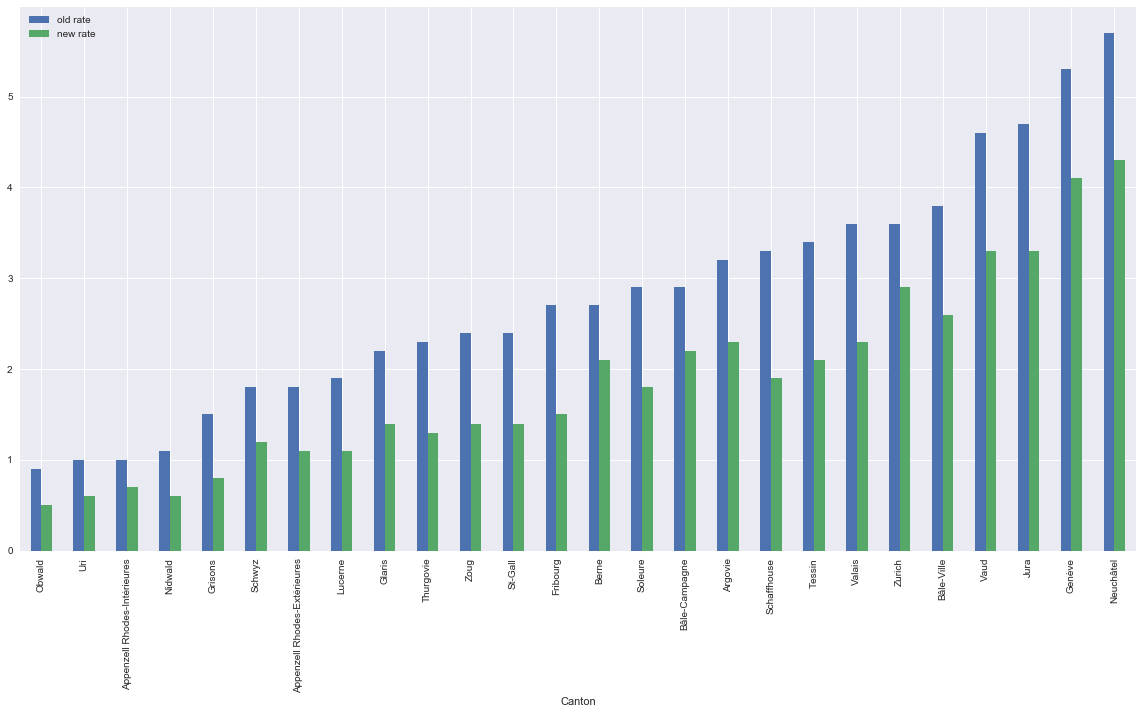

In [40]:
sns.set()
df_difference1 = df_switzerland_unemployment_rate.filter(items = [('Total from Jan. to Sept. 2017','unemployment rate')])
df_difference1.columns = ['old rate']
df_difference1['old rate'] = df_difference1['old rate'].apply(pd.to_numeric)
df_difference1 = df_difference1.reset_index()
df_difference2 = df_ch_unemp_rate_v2.filter(items = [('Canton',''),('Total from Jan. to Sept. 2017','new unemployment rate')])
df_difference2.columns = ['Canton','new rate']
df_diff = pd.merge(df_difference1,df_difference2,on = 'Canton')
df_diff = df_diff.set_index('Canton')
df_diff.sort_values('old rate').plot(kind='bar',figsize=(20,10))
plt.show()

## Question 3: Difference in unemployment rates between different groups

### [Part 1] Difference between the swiss and foreign workers
**Import the umpoloyment rates of Switzerland for 2017 Sept. grouped by nationality(Swiss & Foreigner)**

In [41]:
df_ch_unemp_rate_nation = pd.read_excel("data/ch_unemployment_rate_nationality.xlsx")
df_ch_unemp_rate_nation = df_ch_unemp_rate_nation.drop(['Unnamed: 2','Unnamed: 4'], axis = 1)
df_ch_unemp_rate_nation.columns = ['Canton','Nationality','Unemployment Rate']
df_ch_unemp_rate_nation = df_ch_unemp_rate_nation.drop([0,1,2,55], axis = 0)
df_ch_unemp_rate_nation = df_ch_unemp_rate_nation.set_index(['Canton'])
df_ch_unemp_rate_nation.head()

,Nationality,Unemployment Rate
Canton,,
Zurich,Etrangers,5.3
Zurich,Suisses,2.5
Berne,Etrangers,5.5
Berne,Suisses,1.8
Lucerne,Etrangers,3.9


Umpoloyment rates of foreigners.

In [42]:
df_ch_unemp_rate_foreign = df_ch_unemp_rate_nation[df_ch_unemp_rate_nation['Nationality'] == 'Etrangers']
df_ch_unemp_rate_foreign = df_ch_unemp_rate_foreign.filter(items = ['Unemployment Rate'])
df_ch_unemp_rate_foreign = df_ch_unemp_rate_foreign.reset_index()
df_ch_unemp_rate_foreign['Code'] = code
df_ch_unemp_rate_foreign['Unemployment Rate'] = df_ch_unemp_rate_foreign['Unemployment Rate'].apply(pd.to_numeric)
df_ch_unemp_rate_foreign.head()

,Canton,Unemployment Rate,Code
0,Zurich,5.3,ZH
1,Berne,5.5,BE
2,Lucerne,3.9,LU
3,Uri,2.1,UR
4,Schwyz,3.4,SZ


Umpoloyment rates of swiss.

In [43]:
df_ch_unemp_rate_suisses = df_ch_unemp_rate_nation[df_ch_unemp_rate_nation['Nationality'] == 'Suisses']
df_ch_unemp_rate_suisses = df_ch_unemp_rate_suisses.filter(items = ['Unemployment Rate'])
df_ch_unemp_rate_suisses = df_ch_unemp_rate_suisses.reset_index()
df_ch_unemp_rate_suisses['Code'] = code
df_ch_unemp_rate_suisses['Unemployment Rate'] = df_ch_unemp_rate_suisses['Unemployment Rate'].apply(pd.to_numeric)
df_ch_unemp_rate_suisses.head()

,Canton,Unemployment Rate,Code
0,Zurich,2.5,ZH
1,Berne,1.8,BE
2,Lucerne,1.3,LU
3,Uri,0.4,UR
4,Schwyz,1.2,SZ


The difference in umpoloyment rates between foreigners and swiss.

In [44]:
df_ch_unemp_rate_diff = pd.DataFrame()
df_ch_unemp_rate_diff['Canton'] = df_ch_unemp_rate_suisses['Canton']
df_ch_unemp_rate_diff['Unemployment Rate'] = df_ch_unemp_rate_foreign['Unemployment Rate'] - df_ch_unemp_rate_suisses['Unemployment Rate']
df_ch_unemp_rate_diff['Code'] = df_ch_unemp_rate_suisses['Code']
df_ch_unemp_rate_diff.head()

,Canton,Unemployment Rate,Code
0,Zurich,2.8,ZH
1,Berne,3.7,BE
2,Lucerne,2.6,LU
3,Uri,1.7,UR
4,Schwyz,2.2,SZ


**Show the difference in unemployment rates between swiss and foreign workers in each canton on the Choropleth map**

We plot three choropleth maps as three layers into one map. Readers can choose which one to display.

In [45]:
def add_choropleth(mapobj, geo_data, data, columns, key_on,threshold_scale,topojson, 
                   fill_color, fill_opacity, line_opacity, legend_name, name):
    mapobj.choropleth(geo_data = geo_data, 
                      data = data,
                      columns = columns,
                      key_on = key_on,
                      threshold_scale = threshold_scale,
                      topojson = topojson,
                      fill_color = fill_color,
                      fill_opacity = fill_opacity,
                      line_opacity = line_opacity,
                      legend_name = legend_name,
                      name = name)
    
    return mapobj

In the choropleth map below, we use the same color and data intervals for Foreigners and Swiss. It may be not a good color and interval choice when drawing map for only one of them. But when comparing these two layers, readers can feel the difference of color intuitively. And that's why we use this kind of color and data interval. 

By the way, we also draw the map of Difference. 

In [46]:
map_rate_foreign_swiss = folium.Map(location = switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
map_rate_foreign_swiss = add_choropleth(map_rate_foreign_swiss, geo_json_data, df_ch_unemp_rate_foreign, 
                                        ['Code', 'Unemployment Rate'], 
                                        'feature.id',[2,4,6,8,10],'objects.cantons', 'OrRd', 0.7, 0.2, 
                                        '2017 Switzerland Average Unemployment Rate(%) for Foreigners',
                                        'Foreigners')
map_rate_foreign_swiss = add_choropleth(map_rate_foreign_swiss, geo_json_data, df_ch_unemp_rate_suisses, 
                                        ['Code', 'Unemployment Rate'], 
                                        'feature.id',[2,4,6,8,10],'objects.cantons', 'OrRd', 0.7, 0.2, 
                                        '2017 Switzerland Average Unemployment Rate(%) for Swiss',
                                        'Swiss')
map_rate_foreign_swiss = add_choropleth(map_rate_foreign_swiss, geo_json_data, df_ch_unemp_rate_diff, 
                                        ['Code', 'Unemployment Rate'], 
                                        'feature.id',None,'objects.cantons', 'BuPu', 0.7, 0.2, 
                                        'Difference in Average Unemployment Rate(%)',
                                        'Difference: Foreigners-Swiss')

folium.LayerControl(collapsed=False).add_to(map_rate_foreign_swiss)

map_rate_foreign_swiss

In [47]:
map_rate_foreign_swiss.save('switzerland_rate_foreign_swiss_map.html')

Now, you can see the map we draw with the link: [Switzerland Unempolyment Rate By Nationality](switzerland_rate_foreign_swiss_map.html)

**Analysis:**

**Jura** is the place where the differences most visible. There might be various reasons. Maybe it's becaues the local policy which makes foreigners hard to get working permit in that area. Or maybe it's about the local economic development not requiring a lot of foreigners. Or maybe in Jura, most of people, even foreigners have great social insurance so foreigners don't need to work.



### [Part 2] Difference among 3 age groups: 15-24, 25-49, 50+

**Import the umpoloyment rates of Switzerland for 2017 Sept. grouped by age**

In [48]:
df_ch_unemp_rate_age = pd.read_excel("data/ch_unemployment_rate_age.xlsx")
df_ch_unemp_rate_age = df_ch_unemp_rate_age.drop(['Unnamed: 1', 'Unnamed: 3','Unnamed: 5'], axis = 1)
df_ch_unemp_rate_age.columns = ['Canton','Age Group','Unemployment Rate']
df_ch_unemp_rate_age = df_ch_unemp_rate_age.drop([0,1,2,81],axis = 0)
df_ch_unemp_rate_age = df_ch_unemp_rate_age.set_index(['Canton'])
df_ch_unemp_rate_age.head()

,Age Group,Unemployment Rate
Canton,,
Zurich,15-24 ans,3.7
Zurich,25-49 ans,3.4
Zurich,50 ans et plus,2.9
Berne,15-24 ans,2.8
Berne,25-49 ans,2.5


In [49]:
df_plot = df_ch_unemp_rate_age.filter(items = ['Age Group','Unemployment Rate'],axis = 1)
df_plot.columns = ['Age','Rate']
df_plot = df_plot.reset_index()
df_plot = df_plot.set_index(['Canton','Age'])
df_plot['Rate'] = df_plot['Rate'].apply(pd.to_numeric)
df_plot = df_plot.unstack()
df_plot.columns = ['15-24 ans','25-49 ans','50 ans et plus']
df_plot = df_plot.reset_index()
df_plot.head()

,Canton,15-24 ans,25-49 ans,50 ans et plus
0,Appenzell Rhodes-Extérieures,1.5,1.7,1.8
1,Appenzell Rhodes-Intérieures,1.0,0.5,0.9
2,Argovie,3.3,3.0,2.7
3,Berne,2.8,2.5,2.2
4,Bâle-Campagne,3.2,2.8,2.5


**Show the difference in unemployment rates among 3 age groups in each canton by a stacked bar chart**

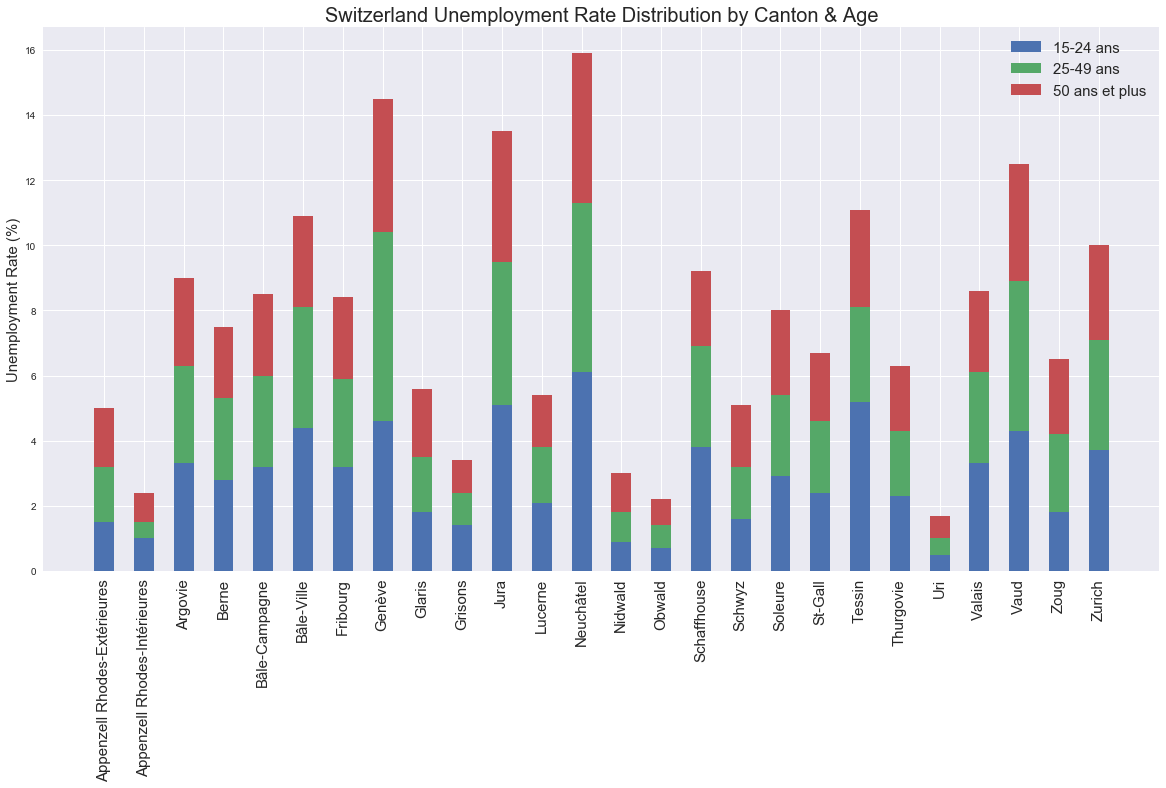

In [50]:
plt.figure(figsize=(20,10))

# The x locations for the groups
ind = np.arange(df_plot.shape[0])

# The width of the bars: can also be len(x) sequence
width = 0.5       

p1 = plt.bar(ind, df_plot['15-24 ans'], width)
p2 = plt.bar(ind, df_plot['25-49 ans'], width, bottom = df_plot['15-24 ans'])
p3 = plt.bar(ind, df_plot['50 ans et plus'], width, bottom = df_plot['15-24 ans'] + df_plot['25-49 ans'])

plt.ylabel('Unemployment Rate (%)',size=15)
plt.title('Switzerland Unemployment Rate Distribution by Canton & Age',size=20)
plt.xticks(ind, df_plot['Canton'], rotation='vertical', size=15)
plt.legend((p1[0], p2[0], p3[0]), ('15-24 ans', '25-49 ans', '50 ans et plus'),fontsize=15)

plt.show()

**Show the difference in unemployment rates among 3 age groups in each canton on the Choropleth map**

In [51]:
def category_by_age(age_group):
    df_temp = df_ch_unemp_rate_age[df_ch_unemp_rate_age['Age Group'] == age_group]
    df_temp = df_temp.filter(items = ['Unemployment Rate'])
    df_temp = df_temp.reset_index()
    df_temp['Code'] = code
    df_temp['Unemployment Rate'] = df_temp['Unemployment Rate'].apply(pd.to_numeric)
    return df_temp

In [52]:
df_ch_unemp_rate_age_15 = category_by_age('15-24 ans')
df_ch_unemp_rate_age_15.head()

,Canton,Unemployment Rate,Code
0,Zurich,3.7,ZH
1,Berne,2.8,BE
2,Lucerne,2.1,LU
3,Uri,0.5,UR
4,Schwyz,1.6,SZ


In [53]:
df_ch_unemp_rate_age_25 = category_by_age('25-49 ans')
df_ch_unemp_rate_age_25.head()

,Canton,Unemployment Rate,Code
0,Zurich,3.4,ZH
1,Berne,2.5,BE
2,Lucerne,1.7,LU
3,Uri,0.5,UR
4,Schwyz,1.6,SZ


In [54]:
df_ch_unemp_rate_age_50 = category_by_age('50 ans et plus')
df_ch_unemp_rate_age_50.head()

,Canton,Unemployment Rate,Code
0,Zurich,2.9,ZH
1,Berne,2.2,BE
2,Lucerne,1.6,LU
3,Uri,0.7,UR
4,Schwyz,1.9,SZ


In the choropleth maps below, we use the same color for three different layers. Readers can choose which one to display. And because three layers are in the same color and use the same intervals, readers are able to find the difference, if any, between three layers.

In [55]:
map_rate_age = folium.Map(location = switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
map_rate_age = add_choropleth(map_rate_age, geo_json_data, df_ch_unemp_rate_age_15, 
                                        ['Code', 'Unemployment Rate'], 
                                        'feature.id',[1,2,3,4,5,6],'objects.cantons', 'BuPu', 0.7, 0.2, 
                                        '2017 Switzerland Average Unemployment Rate(%) for 15-24 years old people',
                                        '15-24 years old')
map_rate_age = add_choropleth(map_rate_age, geo_json_data, df_ch_unemp_rate_age_25, 
                                        ['Code', 'Unemployment Rate'], 
                                        'feature.id',[1,2,3,4,5,6],'objects.cantons', 'BuPu', 0.7, 0.2, 
                                        '2017 Switzerland Average Unemployment Rate(%) for 25-49 years old people',
                                        '25-49 years old')
map_rate_age = add_choropleth(map_rate_age, geo_json_data, df_ch_unemp_rate_age_50, 
                                        ['Code', 'Unemployment Rate'], 
                                        'feature.id',[1,2,3,4,5,6],'objects.cantons', 'BuPu', 0.7, 0.2, 
                                        '2017 Switzerland Average Unemployment Rate(%) for 50+ years old people',
                                        '50+ years old')
folium.LayerControl(collapsed=False).add_to(map_rate_age)

map_rate_age

In [56]:
map_rate_age.save('switzerland_rate_age_map.html')

Now, you can see the map we draw with the link: [Switzerland Unempolyment Rate By Age group](switzerland_rate_age_map.html)

**Analysis:**

As we can see from the choropleth map and the stacked bar plot. In the map, it's hard for readers to intuitively find the difference between three groups. However with the bar chart, it's much more clear for the comparison between different groups in different cantons. So, for this type of multivariable data, bar chart may be a better idea.

From the stacked bar chart, we find that the unemployment rate of the age group 15-24 years old is much higher than that of the other two age groups in most cantons. 

From the choropleth maps, we observe that the rate distribution of these 3 age groups is almost the same, especially for the higher unemployment rate cantons.

### [Part 3] Difference between swiss and foreign workers categorized by 3 age groups

**Import the umpoloyment rates of Switzerland for 2017 Sept. grouped by nationality and age**

In [57]:
df_ch_unemp_rate_age_nation = pd.read_excel("data/ch_unemployment_rate_age_nationality.xlsx")
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.drop(['Unnamed: 2','Unnamed: 4'], axis = 1)
df_ch_unemp_rate_age_nation.columns = ['Canton','Nationality','Age Group','Unemployee','Total Jobseeker','Employed Jobseeker']
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.drop([0,1,2,237], axis = 0)
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.set_index(['Canton'])
df_ch_unemp_rate_age_nation.head()

,Nationality,Age Group,Unemployee,Total Jobseeker,Employed Jobseeker
Canton,,,,,
Zurich,Etrangers,15-24 ans,1015,1178,163
Zurich,Etrangers,25-49 ans,8846,11188,2342
Zurich,Etrangers,50 ans et plus,2250,3018,768
Zurich,Etrangers,NaN,12111,15384,3273
Zurich,Suisses,15-24 ans,2405,2671,266


As the unemployment rate is not provided by the new dataframe when we would like to categorize the data by Nationality and age group at the same time,we are supposed to calculate the unemployment rate by ourselves. This time, we assume **the active population as the total jobseekers** because we are not provided the total population for each group from the dataset. 

Thus, in this part, the unemployment rate is calculated as follows:
$$UnemploymentRate = \frac{\#Unemployee}{\#TotalJobseeker}$$

We calculate the unemployment of each canton and of each age group.

In [58]:
df_ch_unemp_rate_age_nation['Unemployment Rate'] = df_ch_unemp_rate_age_nation['Unemployee'] / df_ch_unemp_rate_age_nation['Total Jobseeker'] * 100
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.filter(items = ['Nationality','Age Group','Unemployment Rate'],axis = 1)
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.reset_index()
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.fillna('unknown')
df_ch_unemp_rate_age_nation.head()

,Canton,Nationality,Age Group,Unemployment Rate
0,Zurich,Etrangers,15-24 ans,86.162988
1,Zurich,Etrangers,25-49 ans,79.066857
2,Zurich,Etrangers,50 ans et plus,74.552684
3,Zurich,Etrangers,unknown,78.724649
4,Zurich,Suisses,15-24 ans,90.041183


**Show the difference in unemployment rates between swiss and foreign workers among 3 age groups in each canton by a stacked bar chart**

In [59]:
df_ch_unemp_rate_age_nation = df_ch_unemp_rate_age_nation.loc[~(df_ch_unemp_rate_age_nation['Age Group'] == 'unknown') 
                                  & df_ch_unemp_rate_age_nation['Nationality'].isin(['Etrangers','Suisses'])]
temp = df_ch_unemp_rate_age_nation.set_index(['Canton','Age Group','Nationality']).unstack().unstack()

temp.head()

Unemployment Rate                            \
Nationality                          Etrangers                             
Age Group                            15-24 ans  25-49 ans 50 ans et plus   
Canton                                                                     
Appenzell Rhodes-Extérieures         72.413793  56.250000      58.823529   
Appenzell Rhodes-Intérieures         75.000000  58.823529      87.500000   
Argovie                              75.665399  67.800124      66.247002   
Berne                                82.686981  70.869844      67.695473   
Bâle-Campagne                        87.301587  68.233083      67.992048   

                                                                    
Nationality                      Suisses                            
Age Group                      15-24 ans  25-49 ans 50 ans et plus  
Canton                                                              
Appenzell Rhodes-Extérieures   61.111111  62.139918      60.816327  
Appenzell Rhodes-Intérieures  100.000000  56.000000      44.117647  
Argovie                        81.324278  72.746222      68.866269  
Berne                          83.541295  76.659787      71.854058  
Bâle-Campagne                  85.885167  77.675841      71.476230

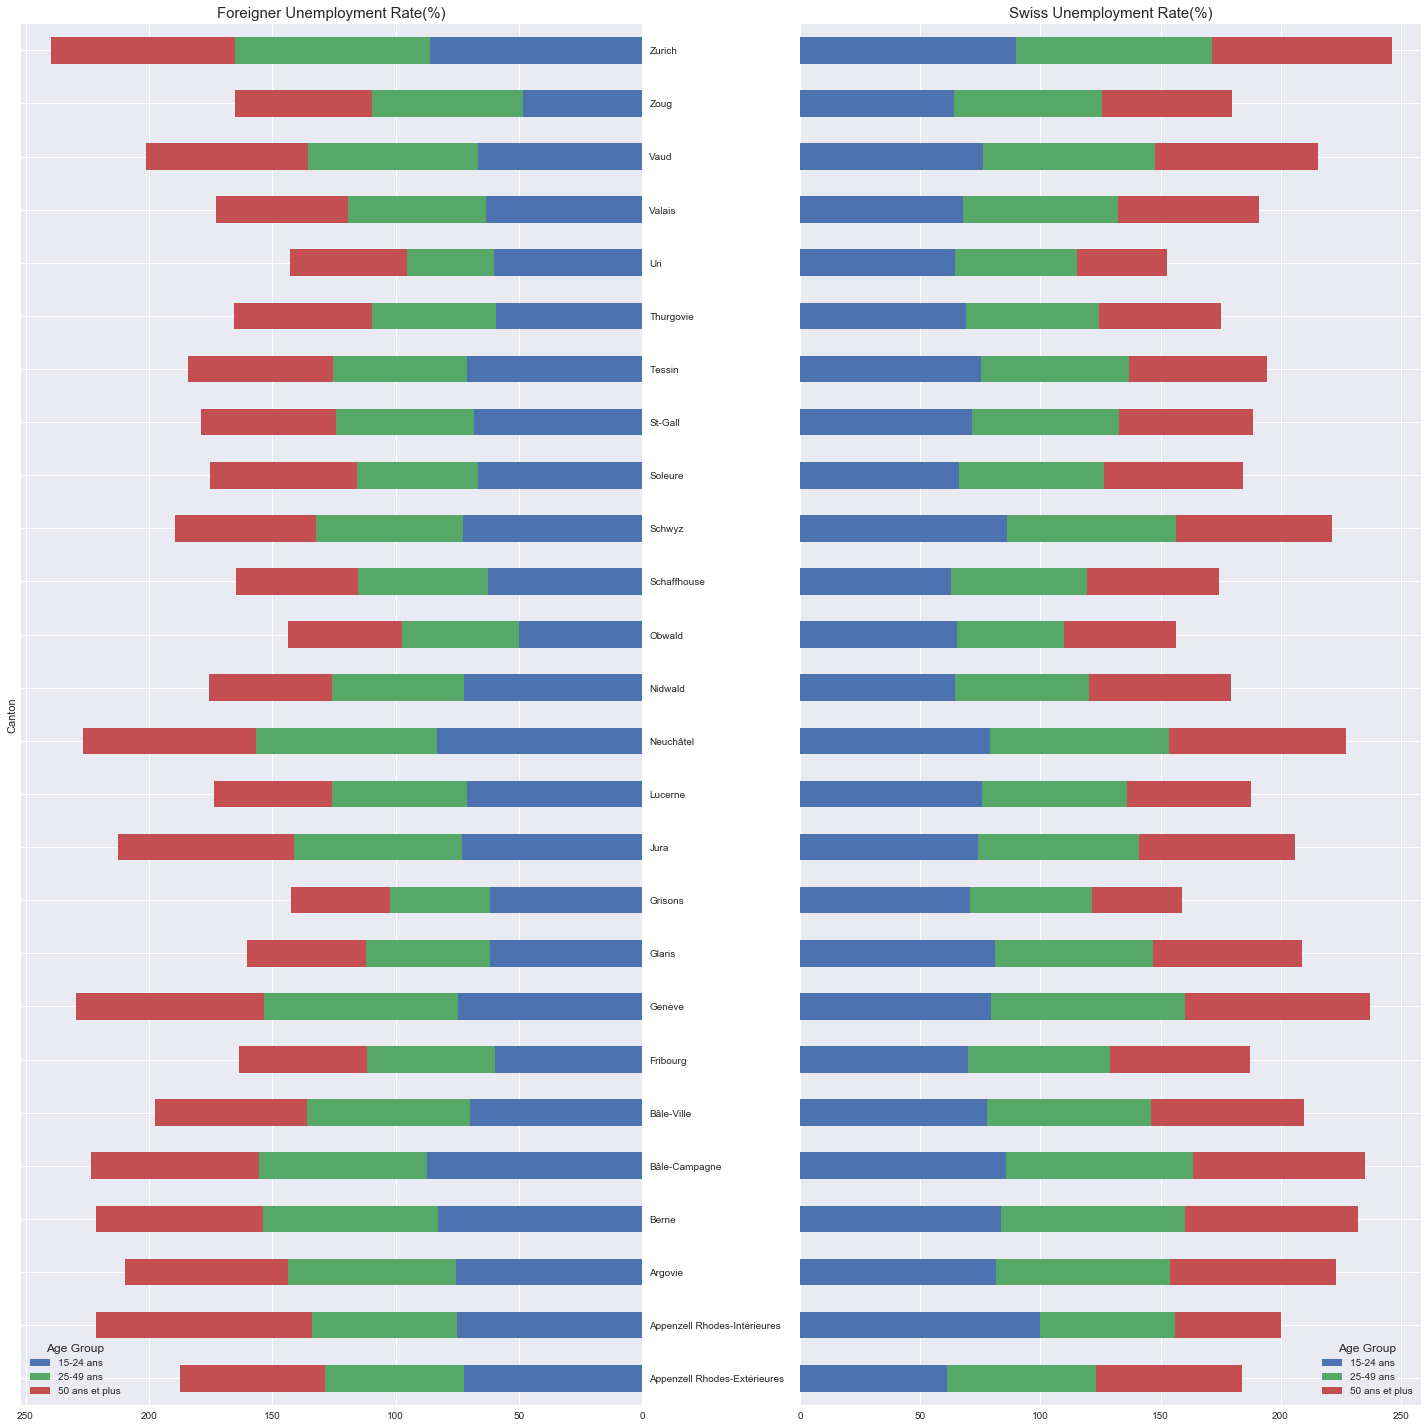

In [60]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(20,20))
temp[('Unemployment Rate','Etrangers')].plot(kind='barh',stacked=True, ax=ax1)
temp[('Unemployment Rate','Suisses')].plot(kind='barh',stacked=True,  ax=ax2)

ax1.axes.invert_xaxis()
ax1.yaxis.set_ticks_position('right')

ax1.set_title('Foreigner Unemployment Rate(%)',size =15)
ax2.set_title('Swiss Unemployment Rate(%)',size =15)

ax1.tick_params(axis='y',labelsize=10)
ax1.tick_params(axis='x',labelsize=10)
ax2.tick_params(axis='x',labelsize=10)

fig.tight_layout()
plt.show()

**Analysis:**

As we can see from the two bar chart above, in each canton, the distribution of unemployment rate among 3 age groups for foreigner and swiss is similar. In other words, in those cantons where young/old foreigner people have difficulty finding a job, so do the young/old swiss. The unemployment rate is highly depend on the economic structure and development of each canton, although, due to the policy the difficulty of finding a job may be different between swiss and foreigners.

## Bonus: 

### Estimate roughly the difference in unemployment rates between the areas divided by the Röstigraben

By definition, Röstigraben (literally "Rösti ditch") is a **humorous term** used to refer to the **cultural boundary between German-speaking and French-speaking parts of Switzerland**. Thus in this part, we analyze the difference of the unemployement rate between German-speaking and French-speaking parts of Switzerland.

In [61]:
import copy
geo_json_data_German = copy.deepcopy(geo_json_data)
geo_json_data_French = copy.deepcopy(geo_json_data)

In [62]:
del geo_json_data_German["objects"]["cantons"]["geometries"][20:]
del geo_json_data_French["objects"]["cantons"]["geometries"][:21]

In order to show the difference in unemployment rates between the areas divided by the Röstigraben, we decided to divide the area into two parts: French-speaking Switzerland and German-speaking Switzerland. Firstly,we need to obtain the information for each part from geo_json_data.

PS: According to Röstigraben, **bilingual cantons are assumed as German-speaking area**.

In [63]:
df_ch_unemp_rate_v3=df_ch_unemp_rate_v2.reset_index()
df_ch_unemp_rate_v3.head()

index   Canton Total from Jan. to Sept. 2017                    \
                                    unemployer active population   
0     0   Zurich                        263669           9096583   
1     1    Berne                        134156           6525666   
2     2  Lucerne                         38319           3426473   
3     3      Uri                          1776            318800   
4     4   Schwyz                         14051           1179388   

                        Code Canton coordinates  
  new unemployment rate                          
0                   2.9   ZH        [47.4, 8.6]  
1                   2.1   BE        [46.8, 7.5]  
2                   1.1   LU      [47.08, 8.17]  
3                   0.6   UR      [46.75, 8.55]  
4                   1.2   SZ        [47.0, 8.7]

In [64]:
canton_French = ['Vaud','Valais', 'Neuchâtel', 'Genève','Jura']
canton_German = ['Zurich','Berne','Lucerne','Uri','Schwyz','Obwald','Nidwald','Glaris','Zoug','Fribourg','Soleure','Bâle-Ville','Bâle-Campagne',
                'Schaffhouse','Appenzell Rhodes-Extérieures','Appenzell Rhodes-Intérieures','St-Gall', 'Grisons', 'Argovie',
                'Thurgovie', 'Valais']

We also divide the data for unemployment rate into two part. And then show the unemployment rate for each part in the map.

In [65]:
df_ch_unemp_rate_French = df_ch_unemp_rate_v3[df_ch_unemp_rate_v3['Canton'].isin(canton_French)]
df_ch_unemp_rate_German = df_ch_unemp_rate_v3[df_ch_unemp_rate_v3['Canton'].isin(canton_German)]

Below, as explained above, we use the same color and intervals for two groups in order to see the difference intuitively.

In [66]:
map_rate_lang = folium.Map(location = switzerland_coord, tiles='cartodbpositron', zoom_start = 8)
map_rate_lang = add_choropleth(map_rate_lang, geo_json_data_German, df_ch_unemp_rate_German, 
                                        [('Code',''), ('Total from Jan. to Sept. 2017','new unemployment rate')], 
                                        'feature.id',[1,2,3,4,5,6],'objects.cantons', 'OrRd', 0.7, 0.5, 
                                        '2017 average unemployment rate (%) for German-speaking cantons',
                                        'German-speaking part')
map_rate_lang = add_choropleth(map_rate_lang, geo_json_data_French, df_ch_unemp_rate_French, 
                                        [('Code',''), ('Total from Jan. to Sept. 2017','new unemployment rate')], 
                                        'feature.id',[1,2,3,4,5,6],'objects.cantons','OrRd', 0.7, 0.5, 
                                        '2017 average unemployment rate (%) for French-speaking cantons',
                                        'French-speaking part')
folium.LayerControl(collapsed=False).add_to(map_rate_lang)


map_rate_lang

In [67]:
map_rate_lang.save('switzerland_rate_rostigraben_map.html')

Now, you can see the map we draw with the link: [Switzerland Unempolyment Rate By Röstigraben](switzerland_rate_rostigraben_map.html)

**Analysis:**

According to the map above, it is obvious that the color for German-speaking cantons is lighter than French-speaking Switzerland, which indicates that **the unemployment rate for German-speaking area is lower than French-speaking area**. 

That's actually very interesting for our foreigners, so we just googled it and found one real interesting artile, [Why Geneva’s unemployment is higher than Zurich’s](http://lenews.ch/2015/03/25/why-genevas-unemployment-is-higher-than-zurichs/). If you are also interested in it, have a look. 